## Problem 1 (100 points)

In this problem you will practice implementing LSTM on SST2 data set to do sentiment analysis (binary classification of positive vs. negative).

**Data.** You will use SST2 dataset. Pytorch/torchdata has provide a useful dataloader to automatically download and load the data into batches. In this homework, you need two class, positive and negative, for binary classification. Code of the data loader has been provided in the template. You can modify the data loading part to use different tokenizer.

In [1]:
import torchdata
import torch
import torch.nn as nn
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np

In [2]:
# Prepare data loader
# Feel free to modify the data loading process as needed
padding_idx = 1
bos_idx = 0
eos_idx = 2
batch_size = 16
max_seq_len = 256
# You can use other Tokenizer
xlmr_vocab_path = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
xlmr_spm_model_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"
xmlr_vocab = load_state_dict_from_url(xlmr_vocab_path)

text_transform = T.Sequential(
    T.SentencePieceTokenizer(xlmr_spm_model_path),
    T.VocabTransform(xmlr_vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

train_datapipe = SST2(split="train")
test_datapipe = SST2(split="dev")

def apply_transform(x):
    return text_transform(x[0]), x[1]

train_datapipe = train_datapipe.map(apply_transform)
train_datapipe = train_datapipe.batch(batch_size)
train_datapipe = train_datapipe.rows2columnar(["token_ids", "target"])
train_dataloader = DataLoader(train_datapipe, batch_size=None)

test_datapipe = test_datapipe.map(apply_transform)
test_datapipe = test_datapipe.batch(batch_size)
test_datapipe = test_datapipe.rows2columnar(["token_ids", "target"])
test_dataloader = DataLoader(test_datapipe, batch_size=None)

In [3]:
# finding longest sentence for padding 
longest_sentence = 0

for (i, data) in enumerate(train_dataloader):
    targets = data["target"]
    token_ids = data["token_ids"]
    
    for token in token_ids:
        if len(token) > longest_sentence:
            longest_sentence = len(token)
longest_sentence 

76

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, batch_size):
        super(LSTMModel, self).__init__() 
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2label = nn.Linear(hidden_dim, label_size)

    def forward(self, sentence, hidden):
        embeds = self.word_embeddings(sentence)
        lstm_out, hidden = self.lstm(embeds, hidden)
        y  = self.hidden2label(lstm_out)
        y = y.mean(axis=1)
        return torch.sigmoid(y), hidden

In [5]:
embedding_dim = 5
hidden_dim = 1
vocab_size = len(xmlr_vocab)
label_size = 1
batch_size = 16
model = LSTMModel(embedding_dim, hidden_dim, vocab_size, label_size, batch_size).cuda()

In [6]:
criterion = torch.nn.BCELoss()

In [7]:
test_criterion = torch.nn.BCELoss()

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.9)

### **Problem Description.** Implement **LSTM** with Pytorch to do binary classification.

### (a) (15 points) Print the model architecture.

In [9]:
model

LSTMModel(
  (word_embeddings): Embedding(250002, 5, padding_idx=1)
  (lstm): LSTM(5, 1, batch_first=True)
  (hidden2label): Linear(in_features=1, out_features=1, bias=True)
)

### (b) (10 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Number of Epochs: 30

Learning Rate: 0.1

Momentum: 0.9

Weight Decay: 0.9

In [13]:
with torch.cuda.device(0):
    num_epochs = 30

    avg_losses = list()
    
    hidden0 =(Variable(torch.randn(1, batch_size, hidden_dim)).cuda(),
                Variable(torch.randn(1, batch_size, hidden_dim)).cuda())
    
    hidden_t = None

    for epoch in tqdm(range(num_epochs)):
        batch_losses = list()
        test_losses = list()
        for (i, data) in enumerate(test_dataloader):
            targets = data["target"]
            token_ids = data["token_ids"]
            
            if len(token_ids) != 16:
                continue
            
            for token in token_ids:
                while len(token) != 76:
                    token.append(1)
            
            targets = torch.tensor(targets, dtype=torch.int32).cuda()
            token_ids = torch.tensor(token_ids, dtype=torch.int32).cuda()
            
            prediction, hidden = model.forward(token_ids, hidden_t)
            
            batch_loss = test_criterion(prediction, targets.reshape(-1,1).to(torch.float32))
            
            test_losses.append(batch_loss.detach().cpu().numpy())
            
        for (i, data) in enumerate(train_dataloader):
            targets = data["target"]
            token_ids = data["token_ids"]
            
            if len(token_ids) != 16:
                continue
            
            for token in token_ids:
                while len(token) != 76:
                    token.append(1)
            
            targets = torch.tensor(targets, dtype=torch.int32).cuda()
            token_ids = torch.tensor(token_ids, dtype=torch.int32).cuda()

            optimizer.zero_grad()
            
            if hidden_t == None:
                hidden_t = hidden0
                
            hidden_t = tuple([each.data for each in hidden_t])
            
            prediction, hidden = model.forward(token_ids, hidden_t)

            batch_loss = criterion(prediction, targets.reshape(-1,1).to(torch.float32))

            batch_loss.backward(retain_graph=True)

            optimizer.step()

            batch_losses.append(batch_loss.detach().cpu().numpy())

        avg_epoch_loss = (1 / batch_size) * np.sum(test_losses)
        avg_losses.append(avg_epoch_loss)

100%|███████████████████████████████████████████| 30/30 [05:45<00:00, 11.50s/it]


### (c) (60 points) Report the **Average Test Loss** after every training epoch by generating Average Test Loss vs. Epoch plot. Please report at least **10** epochs. Note that **Average Test Loss** is based on the test set.

In [14]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Average Test Loss')

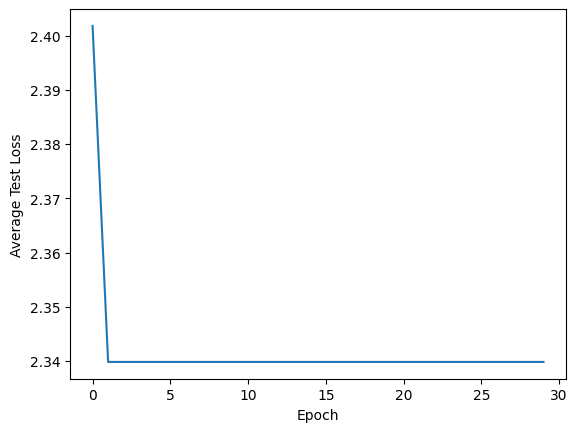

In [15]:
plt.plot(avg_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Test Loss")

### (d) (15 points) Report the final testing accuracy of trained model.

In [58]:
with torch.cuda.device(0):
    correct = 0

    for (i, data) in enumerate(test_dataloader):
        targets = data["target"]
        token_ids = data["token_ids"]
    
        if len(token_ids) != 16:
            continue
            
        for token in token_ids:
            while len(token) != 76:
                token.append(1)
            
        token_ids = torch.tensor(token_ids, dtype=torch.int32).cuda()

        outputs = model.forward(token_ids, hidden_t)[0].round()
        outputs = outputs.detach().cpu().numpy().astype(int).ravel()

        labels = targets

        for output, label in zip(outputs, labels):
            if output == label:
                correct += 1

    accuracy = correct / 880
accuracy

0.5